# Multiclass Classification Illustrated with Tensorflow

In this notebook, we'll extend binary logistic regression to [multiclass logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression). Multiclass logistic regression/classification goes by a variety of names, including *softmax regression*, due to the use of the softmax function (which generalizes the logistic function).

In [1]:
# Import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")
import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

2023-01-31 16:16:57.924467: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data for Modeling
Below, we'll train models on the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. This dataset consists of 70,000 grayscale 28x28 images. Each image is associated with 1 of 10 classes. The dataset was split by the creators; there are 60,000 training images and 10,000 test images. 

Fashion MNIST classes:
* T-shirt/top
* Trouser
* Pullover
* Dress
* Coat
* Sandal
* Shirt
* Sneaker
* Bag
* Ankle boot

### Step 1: Load the Data
Tensorflow includes a growing [library of datasets](https://www.tensorflow.org/datasets/catalog/overview) and makes it easy to load them in numpy arrays.

In [2]:
from keras.datasets import fashion_mnist

# Load the Fashion MNIST dataset and normalize the data
# Note: Pixel values range from 0 to 255 - to normalize the data, we need to divide all values by 255
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
X_train = X_train / 255
X_test = X_test / 255

# Flatten Y_train and Y_test so they become vectors of label values
# Note: The label for X_train[0] is in Y_train[0]
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

label_names = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

# Apply random shuffling to training examples
np.random.seed(0) # set random seed for reproducibility
indices = np.arange(X_train.shape[0])
shuffled_indices = np.random.permutation(indices)
X_train = X_train[shuffled_indices]
Y_train = Y_train[shuffled_indices]

## Cross-Entropy Loss

For binary classification, we use the Log Loss function (also called Binary Cross-Entropy):

\begin{equation}
-y log(\hat{y}) + (1−y)log(1−\hat{y})
\end{equation}

In the above formulation, it is assumed that $y$ is either 0 or 1, so either the left term or the right term is active for each example.

The general form for cross-entropy is used when $y$ is assumed to be a label vector with a 1 in the index of the true label and a 0 everywhere else: $y=[0,0,0,0,0,0,0,1,0,0]$ implies a label of "sneaker" in this dataset (the 7th label). Accordingly, $\hat{y}$ is a vector of predicted probabilities. Then the Cross-Entropy Loss is simply:

\begin{equation}
-\sum_{j} y_j log(\hat{y}_j)
\end{equation}

As in the binary case, this summation will have exactly 1 non-zero term where the true label $y_j=1$.

This formulation is using a *dense* representation of the label. The corresponding *sparse* representation would use the non-zero index directly ($y=7$).

### Step 2: Build a Model

We'll construct a model with a multi-class output and check that training works:
* The output will include 10 probabilities instead of 1.
* For multiclass classification, we'll use a softmax function instead of a sigmoid.
* For the loss function, we'll use [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) instead of binary_crossentropy. Note: "Sparse" refers to the use of a sparse index (e.g., 7) to indicate the label rather than a dense vector (e.g., [0,0,0,0,0,0,0,1,0,0]).

In [3]:
def build_model(n_classes, learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset.
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
    # Clear extra copies of graph and set seed for results consistency
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Build a model using keras.Sequential
    model = keras.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
        units=n_classes,              # output dim (for multi-class classification)
        use_bias=True,                # use a bias param
        activation="softmax"          # apply the softmax function
    ))
    
    # Use mini-batch SGD for optimization
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    
    # Compile the model and specify loss function to finalize the graph for training
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [4]:
# Build the model
model = build_model(n_classes=10, learning_rate=0.01)

# Evaluate model loss
history = model.fit(
  x = X_train,
  y = Y_train,
  epochs=5,
  batch_size=64,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

2023-01-31 16:17:05.118284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
844/844 [==============================] - 1s 1ms/step - loss: 1.0151 - accuracy: 0.6800 - val_loss: 0.7668 - val_accuracy: 0.7490
Epoch 2/5
844/844 [==============================] - 1s 1ms/step - loss: 0.6861 - accuracy: 0.7806 - val_loss: 0.6679 - val_accuracy: 0.7805
Epoch 3/5
844/844 [==============================] - 1s 1ms/step - loss: 0.6165 - accuracy: 0.8026 - val_loss: 0.6225 - val_accuracy: 0.7915
Epoch 4/5
844/844 [==============================] - 1s 1ms/step - loss: 0.5787 - accuracy: 0.8139 - val_loss: 0.5979 - val_accuracy: 0.7963
Epoch 5/5
844/844 [==============================] - 1s 1ms/step - loss: 0.5543 - accuracy: 0.8209 - val_loss: 0.5755 - val_accuracy: 0.8077


,loss,accuracy,val_loss,val_accuracy
0,1.015143,0.679963,0.766788,0.749000
1,0.686079,0.780648,0.667903,0.780500
2,0.616453,0.802611,0.622475,0.791500
3,0.578730,0.813870,0.597864,0.796333
4,0.554258,0.820926,0.575453,0.807667


### Step 3: Evaluation Metrics

Classification metrics like accuracy, precision, and recall can all be derived from a confusion matrix which displays the counts for all pairs of true label and predicted label. Correct predictions are on the diagonal and incorrect predictions (confusions) are off the diagonal. We'll first get the predicted labels from the model.

In [5]:
# Get labels by taking the argmax (the index with the largest probability)
test_predictions = np.argmax(model.predict(X_test), axis=-1)
print(test_predictions)

313/313 [==============================] - 1s 641us/step
[9 2 1 ... 8 1 5]


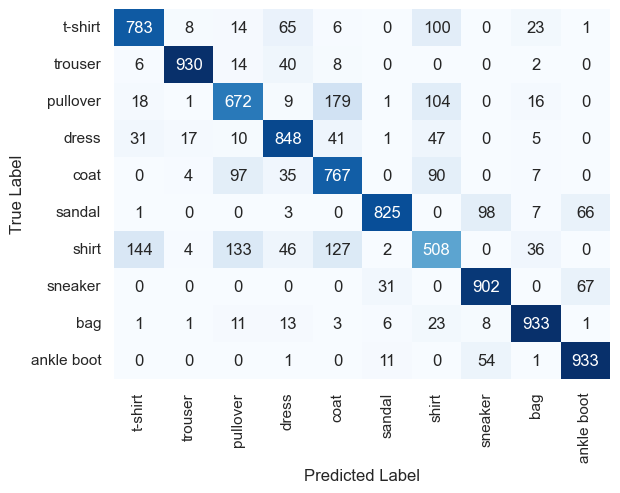

In [6]:
# Create a confusion matrix as a 2D array
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it
ax = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt='.3g',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names,
    cbar=False)

# Add axis labels
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

Based on the results of the confusion matrix and the additional precision summary table created below, the `shirt` class has the *lowest* precision value at **0.5825688073** (or approximately **58.3%**), and the `trouser` class has the *highest* precision value at **0.9637305699** (or approximately **96.4%**).

**Model Precision Rates and Rankings by Class**

Class | Precision | Rank (Highest = 1)
:--- | :--- | :---
T-Shirt | 0.7957317073 | 7
Trouser | 0.9637305699 | 1
Pullover | 0.7066246057 | 8
Dress | 0.8000000000 | 6
Coat | 0.6781609195 | 9
Sandal | 0.9407069555 | 2
Shirt | 0.5825688073 | 10
Sneaker | 0.8493408663 | 5
Bag | 0.9058252427 | 3
Ankle Boot | 0.8735955056 | 4

For the `sneaker` class, the largest source of false negatives is the `ankle boot` class and the largest source of false positives is the `sandal` class. These findings make sense given that sneakers, ankle boots, and sandals are all examples of footware with similarities in shapes and sizes.

### Step 4: Analyze Errors

Analyzing errors will help us understand the shortcomings of the model. While we'd typically want to use the validation set for this purpose to preserve the purity of the test set, we'll just use our test split for simplicity for now. Since the "shirt" class seems to be the source for a lot of errors, we'll take a closer look at some of the model confusions.

We'll investigate by displaying 5 images with true label "shirt", but predicted label "coat" (false negatives for the "shirt" class).

We'll also investigate by displaying 5 images with predicted label "shirt", but true label "coat" (false positives for the "shirt" class).



Part 1: Display 5 images of the shirt class with FN errors -- true label = shirt, predicted label = coat
........................................................................................................


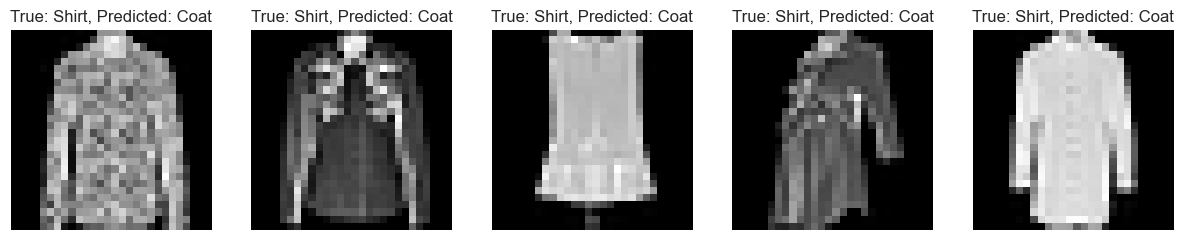




Part 2: Display 5 images of the shirt class with FP errors -- true label = coat, predicted label = shirt
........................................................................................................


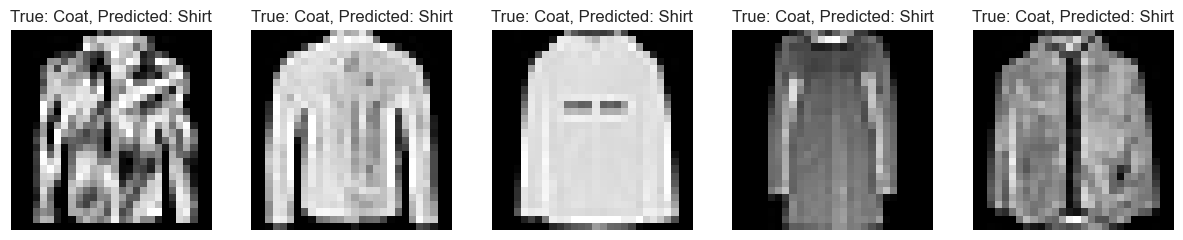

In [7]:
# Reference:
# • Class 0 = t-shirt
# • Class 1 = trouser
# • Class 2 = pullover
# • Class 3 = dress
# • Class 4 = coat
# • Class 5 = sandal
# • Class 6 = shirt
# • Class 7 = sneaker
# • Class 8 = bag
# • Class 9 = ankle boot

## Part 1: Display 5 images of the shirt class with FN errors -- true label = shirt, predicted label = coat
#################################################################################################################

# Define a true label and predicted label for FN errors based on class reference map above
true_label_FN = 6
predicted_label_FN = 4

# Find the indices of the images that have a true label of shirt and predicted label of coat
shirt_indices_FN = np.where(Y_test == true_label_FN)[0]
shirt_coat_indices_FN = [i for i in shirt_indices_FN if test_predictions[i] == predicted_label_FN]

# Identify the first 5 images that represent FN errors
shirt_coat_images_FN = X_test[shirt_coat_indices_FN[:5]]

# Create a figure to plot these 5 examples of FN errors
fig, axes = plt.subplots(1, 5, figsize = (15, 5))
for i, img in enumerate(shirt_coat_images_FN):
    axes[i].imshow(img, cmap = "gray")
    axes[i].set_title("True: Shirt, Predicted: Coat")
    axes[i].axis("off")

# Show the 5 FN images
print("\n")
print("Part 1: Display 5 images of the shirt class with FN errors -- true label = shirt, predicted label = coat")
print("........................................................................................................")
plt.show()

print("\n======================================================================================================")

## Part 2: Display 5 images of the shirt class with FP errors -- predicted label = shirt, true label = coat
#################################################################################################################

# Define a true label and predicted label for FP errors based on class reference map above
true_label_FP = 4
predicted_label_FP = 6

# Find the indices of the images that have a true label of coat and predicted label of shirt
coat_indices_FP = np.where(Y_test == true_label_FP)[0]
coat_shirt_indices_FP = [i for i in coat_indices_FP if test_predictions[i] == predicted_label_FP]

# Identify the first 5 images that represent FP errors
coat_shirt_images_FP = X_test[coat_shirt_indices_FP[:5]]

# Create a figure to plot these 5 examples of FP errors
fig, axes = plt.subplots(1, 5, figsize = (15, 5))
for i, img in enumerate(coat_shirt_images_FP):
    axes[i].imshow(img, cmap = "gray")
    axes[i].set_title("True: Coat, Predicted: Shirt")
    axes[i].axis("off")

# Show the 5 FP images
print("\n")
print("Part 2: Display 5 images of the shirt class with FP errors -- true label = coat, predicted label = shirt")
print("........................................................................................................")
plt.show()

### Step 5: Visualize Parameters
Finally, we'll add some code to help visualize the learned parameters for each class.

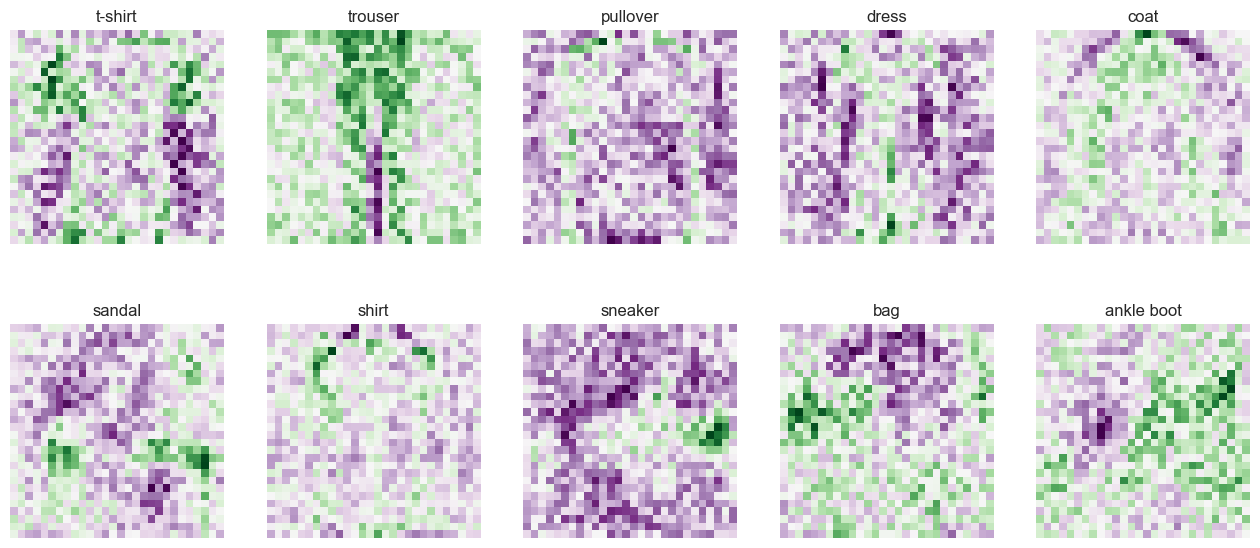

In [8]:
weights, biases = model.layers[1].get_weights()
fig, axs = plt.subplots(2, 5, figsize=(16,7))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(weights[:,i].reshape(28,28), cmap='PRGn')
    ax.axis('off')
    ax.set_title(label_names[i])
plt.show()